## 循环神经网络 RNN（Recurrent Neural Network）
经过测试发现，线性回归好像很难去处理时间维度的数据。

In [179]:
# -*- coding: UTF-8 -*-
"""
此脚本用于展示使用sklearn搭建线性回归模型
"""
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model

In [180]:
def readData(path,sheet):
    """
    使用pandas读取数据
    """
    data = pd.read_excel(path,sheet)
    return data

In [181]:
df1rnn = readData(r'C:\Users\sunch\Desktop\【机器学习测试0930】\test_df_RNN.xlsx','Sheet1')
df1rnn1 = df1rnn.astype({'主时间':'datetime64[ns]'}).set_index('主时间')
df1rnn1

,UV(个),PV(个),SPV_UV(个),访问会员数(个),新UV(个)
主时间,,,,,
2020-01-01,91558,543697,3827,64486,21250
2020-01-02,68736,303812,2019,46001,16258
2020-01-03,57951,250710,1904,38598,13594
2020-01-04,62021,281604,1827,42450,14838
2020-01-05,65805,332932,2216,46337,17180
...,...,...,...,...,...
2021-09-24,21209,62103,1368,13908,5650
2021-09-25,19067,61091,535,14160,4274
2021-09-26,23208,65556,3375,14352,7545


In [182]:
## 指定一下字体，否则作图时候可能报错的。
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False ## 设置正常显示符号

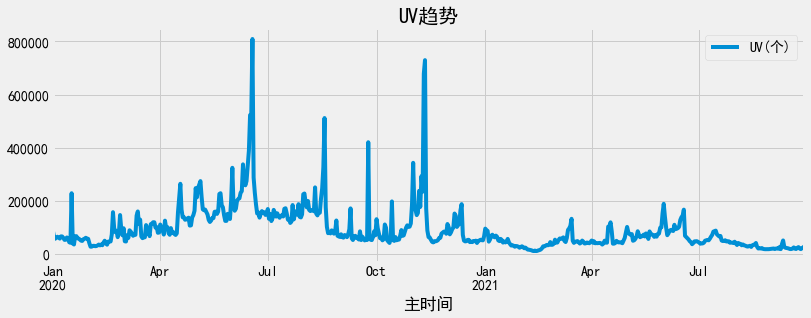

In [183]:
plt.style.use('fivethirtyeight') #设定绘图风格
df1rnn1["UV(个)"].plot(figsize=(12,4),legend=True) #绘制激活数
plt.title('UV趋势') #图题
plt.show() #绘图

### 3 拆分训练集和测试集
.values 这个属性就把 Pandas 对象转换成了 Numpy 数组，我们在上一讲中说过，机器学习中也把 Numpy 数组称为张量，神经网络模型需要 Numpy 张量类型作为输入。


In [184]:
# 按照2021年7月1日为界拆分数据集
Train = df1rnn1[:'2021-03-31'].iloc[:,0:1].values #训练集
Test = df1rnn1['2021-04-01':].iloc[:,0:1].values #测试集

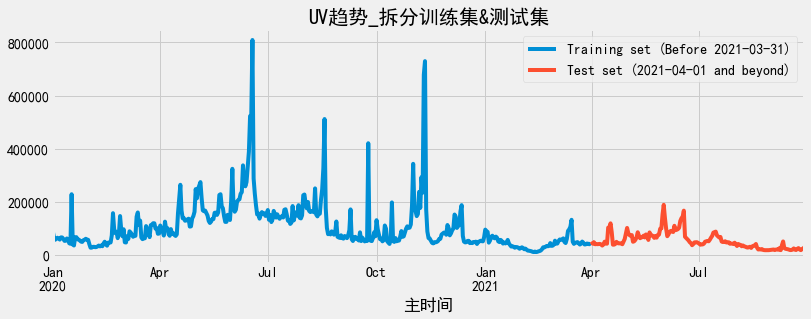

In [185]:
df1rnn1["UV(个)"][:'2021-03-31'].plot(figsize=(12,4),legend=True) #训练集
df1rnn1["UV(个)"]['2021-04-01':].plot(figsize=(12,4),legend=True) #测试集
plt.legend(['Training set (Before 2021-03-31)','Test set (2021-04-01 and beyond)']) #图例
plt.title('UV趋势_拆分训练集&测试集') #图题
plt.show() #绘图

### 4 特征工程
对于神经网络来说，这是一个特别重要的步骤。我们上节课说过，神经网络非常不喜欢数值跨度大的数据，所以，我们对训练特征数据集进行归一化缩放。

In [186]:
# 特征工程
from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
Scaler = MinMaxScaler(feature_range=(0,1)) #创建缩放器
Train = Scaler.fit_transform(Train) #拟合缩放器并对训练集进行归一化

### 5 构建特征集和标签集
我们前面说过，这个数据集的标签就是 App 激活数，特征是时序数据。如果我们要预测今天的 App 下载数量，那时序数据特征的典型构造方法就是，把之前 30 天或者 60 天的 App 下载数量作为特征信息被输入机器学习模型。

所以，在下面的这段代码中，我们创建了一个具有 60 个时间步长（所谓步长，就是时间相关的历史特征数据点）和 1 个输出的数据结构。对于训练集的每一行，我们有 60 个之前的 App 下载数作为特征，1 个当前训练集元素作为标签。

In [187]:
# 创建具有 60 个时间步长和 1 个输出的数据结构 - 训练集
X_train = [] #初始化
y_train = [] #初始化
for i in range(60,Train.size): 
    X_train.append(Train[i-60:i,0]) #构建特征
    y_train.append(Train[i,0]) #构建标签
X_train, y_train = np.array(X_train), np.array(y_train) #转换为NumPy数组
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1)) #转换成神经网络所需的张量形状

在这个过程中的最后一步，我是用 NumPy 中的 reshape 方法，把特征数据集转换成神经网络所需要的形状的。我之所以强调这一点，是因为如果形状不对，程序在训练时就会报错，这个错误对初学者来说很常见。

In [188]:
# 用样的方法处理测试集
TrainTest = df1rnn1["UV(个)"][:] #整体数据
inputs = TrainTest[len(TrainTest)-len(Test) - 60:].values #Test加上前60个时间步
inputs = inputs.reshape(-1,1) #转换形状
inputs  = Scaler.transform(inputs) #归一化
# 创建具有 60 个时间步长和 1 个输出的数据结构 - 测试集
X_test = [] #初始化
y_test = [] #初始化
for i in range(60,inputs.size): 
    X_test.append(inputs[i-60:i,0]) #构建特征
    y_test.append(inputs[i,0]) #构建标签
X_test = np.array(X_test) #转换为NumPy数组
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)) #转换成神经网络所需的张量形状

In [189]:
# 重新设计一下，Xtest

In [190]:
# inputs2 = TrainTest[len(TrainTest)-len(Test) - 60:]
# inputs2['2021-09'] = 0
# inputs3 = inputs2.values
# inputs3 = inputs3.reshape(-1,1)
# inputs3  = Scaler.transform(inputs3)

In [191]:
# X_test = [] #初始化
# y_test = [] #初始化
# for i in range(60,inputs3.size): 
#     X_test.append(inputs3[i-60:i,0]) #构建特征
#     y_test.append(inputs3[i,0]) #构建标签
# X_test = np.array(X_test) #转换为NumPy数组
# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)) #转换成神经网络所需的张量形状

### 6 选择算法
- 循环神经网络 RNN（Recurrent Neural Network）
- 必须从所有过去的句子中保留一些信息，以便能理解整个故事的上下文。
- 在 Kares 中，主要有三种循环神经网络层可以搭建循环神经网络，分别是 Simple RNN、LSTM 和 GRU.
- LSTM（Long Short-Term Memory，长短期记忆网络）LSTM 的神经元由一个遗忘门、一个输入门、一个输出门和一个记忆细胞组成，来记录额外的信息。记忆细胞负责记住时间相关的信息，而三个门负责调节进出神经元的信息流。这个过程中的数学原理我们这里不详述，你只需了解在这个过程中，每个记忆单元可获得连续的梯度流，能学习数百个时间步长的序列而误差保持原值，从而解决梯度消失问题。

#### 6.1 选择算法并建立模型
我们就构建一个以 LSTM 为主要层结构的循环神经网络：

In [192]:
from tensorflow.keras.models import Sequential #导入序贯模型
from tensorflow.keras.layers import Dense, LSTM #导入全连接层和LSTM层
# from keras.optimizers import SGD
# LSTM网络架构
RNN_LSTM = Sequential() #序贯模型
RNN_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))) #输入层LSTM,return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间1层LSTM，return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间2层LSTM，return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50)) #中间3层LSTM
RNN_LSTM.add(Dense(units=1)) #输出层Dense
# 编译网络
# RNN_LSTM.compile(loss='mean_squared_error', #损失函数
#                  optimizer='rmsprop', #优化器
#                  metrics=['mae']) #评估指标
RNN_LSTM.compile(loss='mse', #损失函数
                 optimizer='rmsprop', #优化器
                 metrics=['mae']) #评估指标
RNN_LSTM.summary() #输出神经网络结构信息

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


#### 6.2 训练并评估模型
这里我们训练 50 次，并在训练的同时进行 80/20 比例的数据验证：

In [193]:
# 训练并保存训练历史信息
history = RNN_LSTM.fit(X_train, y_train, # 指定训练集
                  epochs=50,        # 指定训练的轮次
                  batch_size=60,    # 指定数据批量 (这里做调整后，大幅影响收敛速度、并过拟合，并改变预测结果，越大则后续预期侧结果越偏大。)
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便

Train on 316 samples, validate on 80 samples
Epoch 1/50
316/316 [==============================] - 12s 38ms/sample - loss: 0.0260 - mae: 0.1085 - val_loss: 0.0062 - val_mae: 0.0753
Epoch 2/50
316/316 [==============================] - 2s 5ms/sample - loss: 0.0139 - mae: 0.0730 - val_loss: 0.0076 - val_mae: 0.0837
Epoch 3/50
316/316 [==============================] - 2s 5ms/sample - loss: 0.0143 - mae: 0.0760 - val_loss: 0.0075 - val_mae: 0.0836
Epoch 4/50
316/316 [==============================] - 2s 5ms/sample - loss: 0.0138 - mae: 0.0741 - val_loss: 0.0014 - val_mae: 0.0329
Epoch 5/50
316/316 [==============================] - 2s 5ms/sample - loss: 0.0147 - mae: 0.0751 - val_loss: 0.0070 - val_mae: 0.0806
Epoch 6/50
316/316 [==============================] - 2s 5ms/sample - loss: 0.0135 - mae: 0.0715 - val_loss: 0.0054 - val_mae: 0.0702
Epoch 7/50
316/316 [==============================] - 2s 5ms/sample - loss: 0.0140 - mae: 0.0765 - val_loss: 0.0056 - val_mae: 0.0719
Epoch 8/50
316/

In [194]:
def show_history(history): # 显示训练过程中的学习曲线
    loss = history.history['loss'] #训练损失
    val_loss = history.history['val_loss'] #验证损失
    epochs = range(1, len(loss) + 1) #训练轮次
    plt.figure(figsize=(12,4)) # 图片大小
    plt.subplot(1, 2, 1) #子图1
    plt.plot(epochs, loss, 'bo', label='Training loss') #训练损失
    plt.plot(epochs, val_loss, 'b', label='Validation loss') #验证损失
    plt.title('Training and validation loss') #图题
    plt.xlabel('Epochs') #X轴文字
    plt.ylabel('Loss') #Y轴文字
    plt.legend() #图例
    plt.show() #绘图

由于这是一个回归值的预测问题，没有分类准确率指标，仅有损失值这个指标，我们就用上一讲中说过的损失曲线来显示训练过程中损失值的变化.

可以看到，训练 50 轮之后，训练集上的损失已经很小了。不过，测试集上面的损失存在着振荡上升现象，这也是过拟合的一个标志。

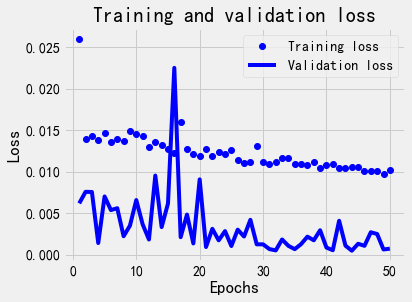

In [195]:
show_history(history) # 调用绘图函数

#### 6.3 利用模型进行预测
让我们用模型预测一下测试集（也就是代表着未来）的激活数吧。不过，在预测结束之后，需要用 inverse_transform 对预测值做反归一化。否则，激活数将是一个 0-1 之间的值。

In [196]:
# 定义绘图函数
def plot_predictions(test,predicted):
    plt.figure(figsize=(12,4)) # 图片大小
    plt.plot(test, color='red',label='Real Count') #真值
    plt.plot(predicted, color='blue',label='Predicted Count') #预测值
    plt.title('UV数预测') #图题
    plt.xlabel('Time') #X轴时间
    plt.ylabel('UV数') #Y轴激活数
    plt.legend() #图例
    plt.show() #绘图

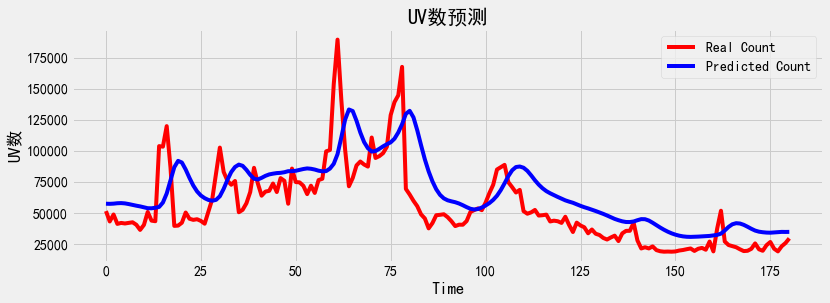

In [197]:
# 【结果来了】
Pred = RNN_LSTM.predict(X_test) #预测
Pred = Scaler.inverse_transform(Pred) #反归一化
plot_predictions(Test,Pred) #绘图

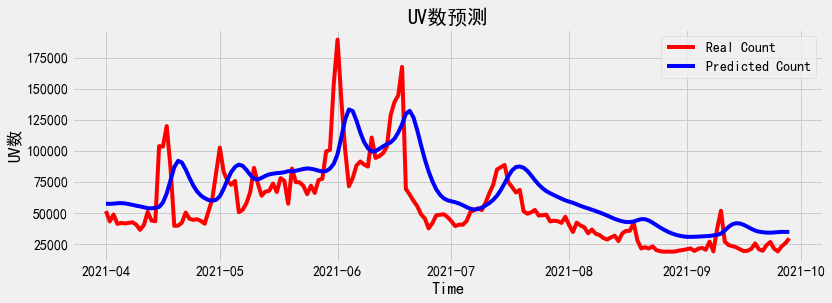

In [198]:
# 前面的预测上x轴没有时间，重新构造一个时间index。
Test2 = pd.DataFrame(Test,index = df1rnn1['2021-04-01':].index,columns = ['测试'])
Pred2 = pd.DataFrame(Pred,index = df1rnn1['2021-04-01':].index,columns = ['预测'])
plot_predictions(Test2,Pred2) #绘图

In [ ]:
Pred2 = RNN_LSTM.predict(X_test2)

In [207]:
X_test[0:2].shape

(2, 60, 1)

In [205]:
X_test.shape

(181, 60, 1)